In [259]:
import sys
sys.path.append('..')
sys.path.append('../beit2')
from datamodules import DATAMODULE_REGISTRY
from models import MODEL_REGISTRY
import torch
from pytorch_lightning import LightningModule
import torch.nn as nn
import opt_einsum
from modules import mask_eos
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
from transformers import BertTokenizer
import scipy
import textwrap
import math
from utils import load_beit2_teacher

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
MODEL_PATH = "/workspace/models/Sx3HRe_t_cmli/model-44632-0.9427-val.ckpt"

In [4]:
coco_dm_kwargs = {
    'data_path': '/workspace',
    'num_max_bpe_tokens': 64,
    'color_jitter': None,
    'beit_transforms': False,
    'crop_scale': [1.0, 1.0],
    'batch_size': 9,
    'num_workers': 1,
    'shuffle': True,
    'drop_last': False,
}

In [5]:
import pytorch_lightning as pl
pl.seed_everything(42)
coco_dm = DATAMODULE_REGISTRY['coco_captions'](**coco_dm_kwargs)

Seed set to 42


In [6]:
coco_dm.prepare_data()
coco_dm.setup('test')

2024-09-18 15:23:58 | INFO | datasets_.base_datasets | [COCOCaptions]: Data already exists under: /workspace/coco
2024-09-18 15:23:58 | INFO | datasets_.base_datasets | [COCOCaptions]: Data already exists under: /workspace/coco
2024-09-18 15:23:59 | INFO | datasets_.base_datasets | [COCOCaptions]: Data already exists under: /workspace/coco
2024-09-18 15:23:59 | INFO | datasets_.base_datasets | [COCOCaptions]: Load 25010 image-text pairs from /workspace/coco/coco_captioning.test.jsonl. 


In [7]:
dl = coco_dm.test_dataloader()

In [337]:
dl_iter = iter(dl)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

module_cls:LightningModule = MODEL_REGISTRY['Sx3HRe']['module']
module = module_cls.load_from_checkpoint(MODEL_PATH)
module = module.to(device)
module.requires_grad_(False)
module.eval()

teacher_args = {
    "drop_path_rate": 0.1,
    "use_shared_rel_pos_bias": True,
    "use_abs_pos_emb": False,
    "vocab_size": 8192,
    "init_values": 0.1,
}

teacher = load_beit2_teacher(
    sd_path="/workspace/models/beitv2_base_patch16_224_pt1k.pth",
    **teacher_args,
)
teacher.requires_grad_(False)
teacher.eval()
teacher = teacher.to(device)

2024-09-18 15:24:02 | INFO | utils | Modality used: Modality.IMAGE
2024-09-18 15:24:02 | INFO | data2vec_fairseq.models.data2vec2 | making target model
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1877: UserWarning: Positional args are being deprecated, use kwargs instead. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(
2024-09-18 15:24:03 | INFO | utils | Loaded state dict, result: <All keys matched successfully>
/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
2024-09-18 15:24:04 | INFO | utils | Loaded BEiT2 teacher state dict with result: <All keys matched successfully>


In [10]:
def fit_text(figure, axes, text):
    bbox = axes.get_position()
    fig_width_inch = figure.get_size_inches()[0]
    axes_width_inch = bbox.width * fig_width_inch
    char_width_inch = 0.1
    max_chars_per_line = int(axes_width_inch / char_width_inch)
    wrapped_text = "\n".join(textwrap.wrap(text, width=max_chars_per_line))
    return wrapped_text

In [11]:
@torch.no_grad()
def t_cmli(module, teacher, text, padding_mask, image, topk=5) -> None:
    text_emb = module.model.encode_text(text=text, padding_mask=padding_mask)['encoder_out'][:, 1:]
    text_emb = module.t_cmli_loss.down_proj(text_emb)
    text_emb = text_emb / text_emb.norm(dim=1, keepdim=True)

    bool_masked_pos = torch.zeros((image.shape[0], teacher.patch_embed.num_patches), 
                                      dtype=torch.bool).to(image.device)
    image_emb = teacher.forward_features(
        x=image,
        bool_masked_pos=bool_masked_pos,
    )[:, 1:]
    image_emb = module.t_cmli_loss.down_proj(image_emb)
    image_emb = image_emb / image_emb.norm(dim=1, keepdim=True)
    sim = opt_einsum.contract('b t d, b i d -> b t i', text_emb, image_emb)

    padding_mask = mask_eos(padding_mask)[:, 1:]

    token2patch_idx = sim.topk(topk, dim=-1).indices
    token2patch_idx_row = token2patch_idx // 14
    token2patch_idx_col = token2patch_idx % 14
    token2patch_coords = torch.stack([token2patch_idx_row, token2patch_idx_col], dim=-1)

    return token2patch_coords, padding_mask

In [300]:
def plot_legend(ax, text_list, colors):
    # Define the maximum number of items per column
    max_items_per_column = 5
    step_size = 1 / max_items_per_column

    # Calculate the number of columns needed
    num_columns = math.ceil(len(text_list) / max_items_per_column)
    
    # Loop through each column
    for col in range(num_columns):
        # Determine the items for this column
        start_idx = col * max_items_per_column
        end_idx = start_idx + max_items_per_column
        column_texts = text_list[start_idx:end_idx]
        column_colors = colors[start_idx:end_idx]

        # Plot the squares and texts for this column
        for i, (color, text) in enumerate(zip(column_colors, column_texts)):
            y = (1-step_size/2)-step_size*i
            x = col*(1/num_columns)
            color[-1] = 0.5 # Set the alpha value to 0.5
            ax.add_patch(plt.Rectangle((x, y), 0.05, 0.05, color=color, ec='black'))
            ax.text(x + 0.08, y+0.025, text.replace('#', ''), fontsize=12, va='center', ha='left')

    ax.axis('off')

def plot_image_(fig, ax, image, tokens, token2patch, colors, titlesize=12) -> None:
    ax.imshow(image.cpu().permute(1, 2, 0))
    
    patch_size = 16

    for color_idx, areas in enumerate(token2patch.tolist()):
        for topk, (row, col) in enumerate(areas):
            x = col*patch_size 
            y = row*patch_size
            color = colors[color_idx]
            color[-1] = 0.5 # Set the alpha value to 0.5
            ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, color=color, ec='black'))
            ax.text(x + 5.5, y + 8.5, str(topk+1), fontsize=15, va='center', ha='left', color="black", fontweight="bold")
    
    ax.set_title(fit_text(fig, axes=ax, text=tokenizer.convert_tokens_to_string(tokens)), fontsize=titlesize)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1)

def plot(image, text, token2patch, padding_mask) -> None:
    default_w, default_h = plt.rcParams['figure.figsize']

    padding_mask[0] = 1.0

    text = text[~padding_mask.bool()]
    token2patch = token2patch[~padding_mask.bool()]

    tokens = tokenizer.convert_ids_to_tokens(text)
    colors = cm.rainbow(np.linspace(0, 1, len(tokens)))

    fig = plt.figure(figsize=(default_w*2, default_h))
    gs = fig.add_gridspec(1, 2, wspace=0, hspace=0.3)
    ax = fig.add_subplot(gs[0, 0])
    plot_image_(fig, ax, image, tokens, token2patch, colors)

    ax = fig.add_subplot(gs[0, 1])
    plot_legend(ax, tokens, colors)
    fig.show()


In [292]:
def plot_token(image_raw, image, text, token2patch, padding_mask, token_no) -> None:
    text = text[~padding_mask.bool()]
    token2patch = token2patch[~padding_mask.bool()]

    tokens = tokenizer.convert_ids_to_tokens(text)

    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(1, 2, wspace=0, hspace=0.5)
    ax = fig.add_subplot(gs[0, 0])

    plot_image(ax, image_raw, token2patch[token_no])

    ax = fig.add_subplot(gs[0, 1])
    attentions = teacher.get_last_selfattention(image.unsqueeze(0)).squeeze()

    nh = 12
    attentions = attentions[:, 1:, 1:].reshape(nh, -1)
    attentions = attentions.reshape(nh, 14, 14, 14, 14)

    attentions = attentions[:, token2patch[token_no][0][0], token2patch[token_no][0][1]]
    attentions = nn.functional.interpolate(attentions.unsqueeze(0), scale_factor=4, mode="bilinear")[0].mean(dim=0).cpu().numpy()
    ax.imshow(attentions)

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1)
    
    fig.suptitle(f'"{tokens[token_no]}"', fontsize=22, horizontalalignment='center')
    fig.show()

def plot_image(ax, image, token2patch) -> None:
    ax.imshow(image.permute(1, 2, 0))
    
    patch_size = 16

    for topk, (row, col) in enumerate(token2patch.tolist()):
        x = col*patch_size 
        y = row*patch_size
        ax.add_patch(plt.Rectangle((x, y), patch_size, patch_size, color=[1,1,1,0.5], ec='black'))
        ax.text(x + 5.5, y + 8.5, str(topk+1), fontsize=15, va='center', ha='left', color="black", fontweight="bold")

    ax.set_xticks([])
    ax.set_yticks([])
    for spine in ax.spines.values():
        spine.set_edgecolor("black")
        spine.set_linewidth(1)

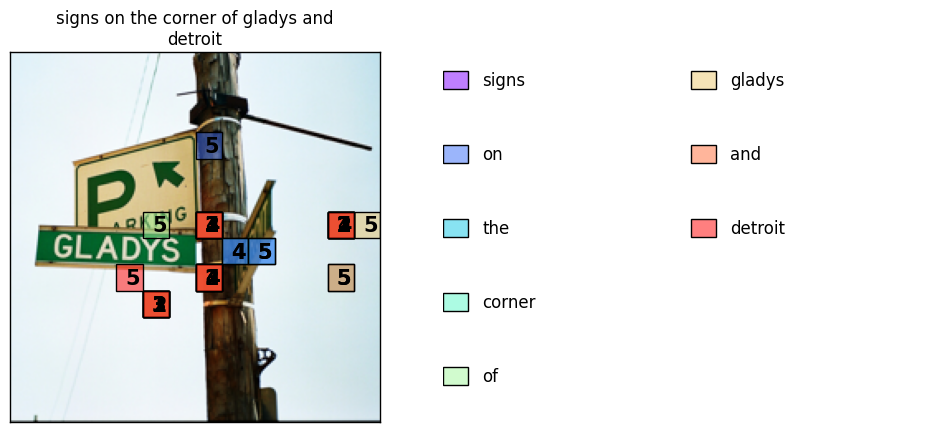

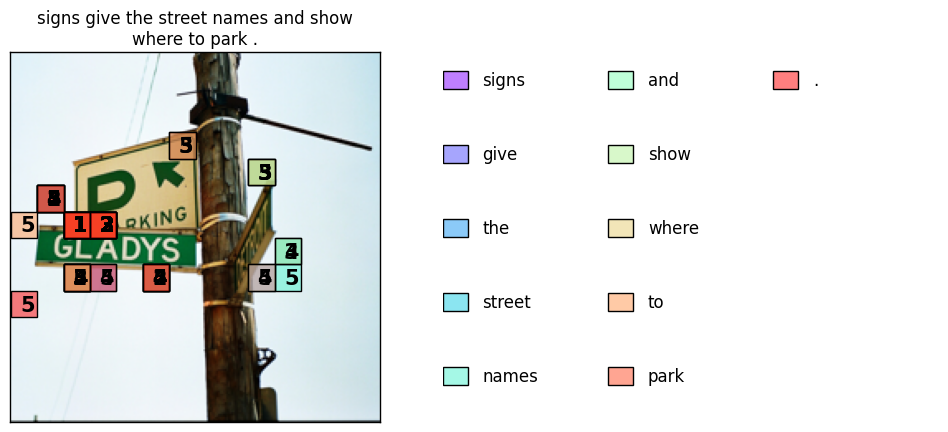

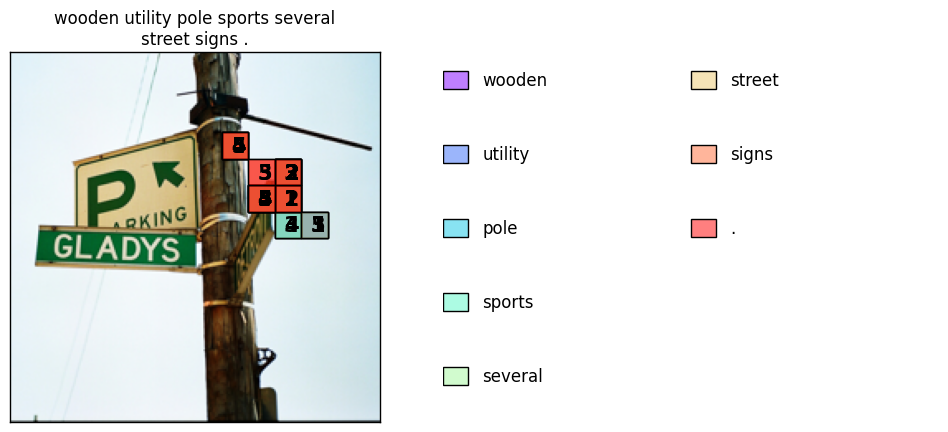

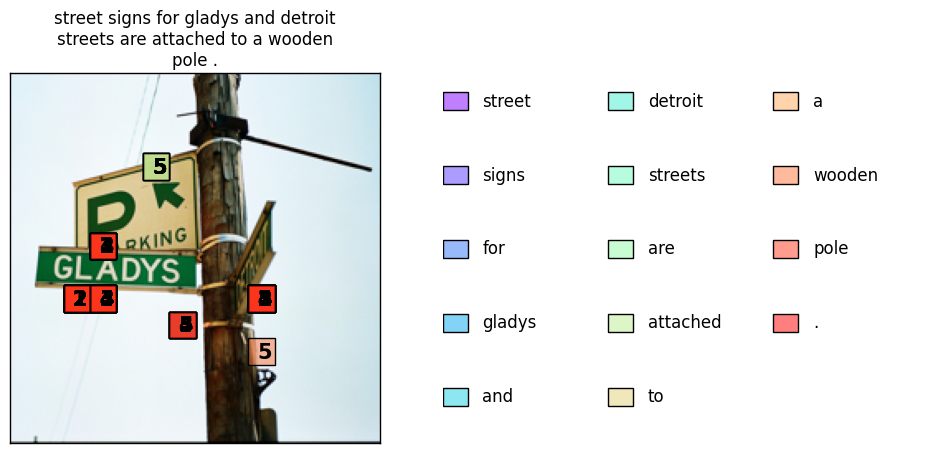

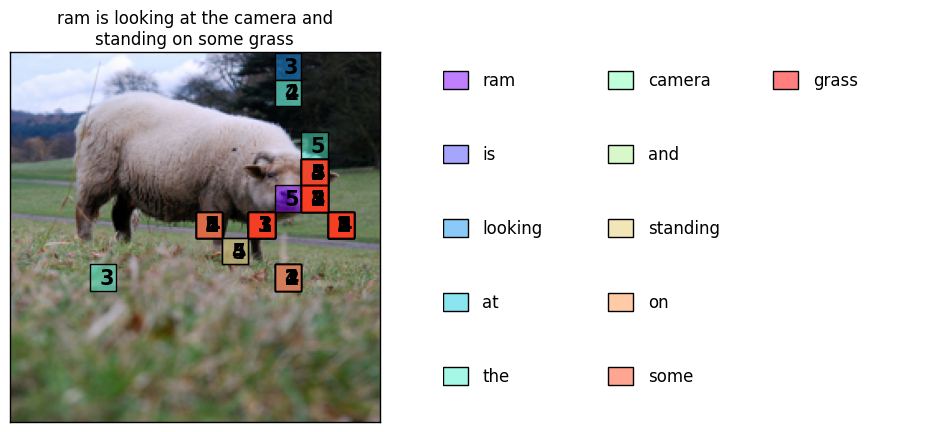

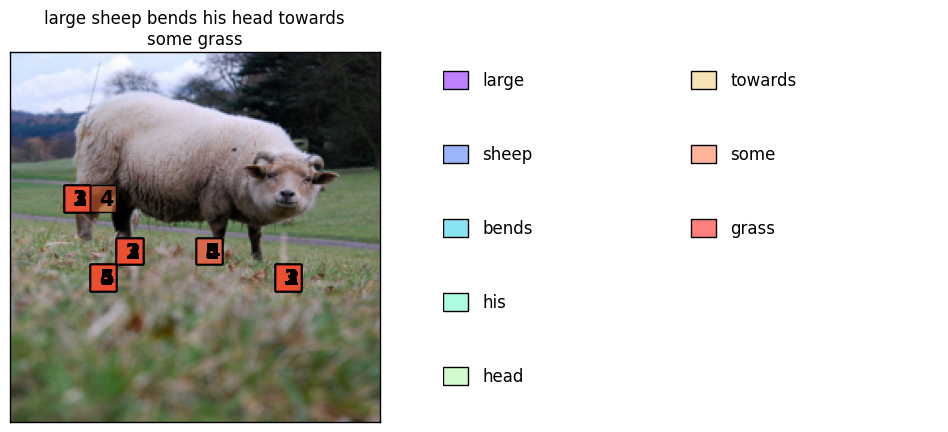

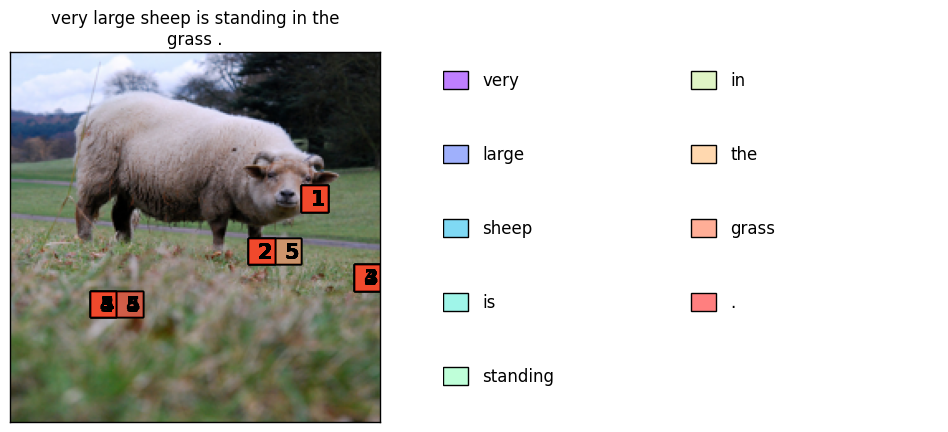

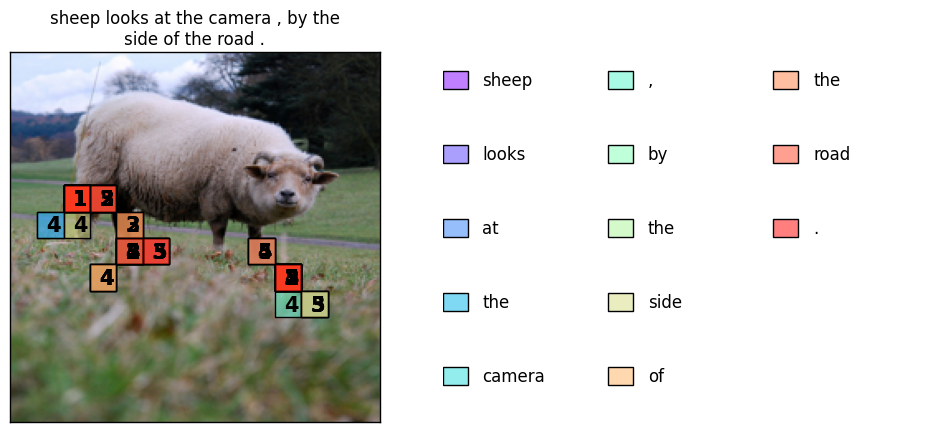

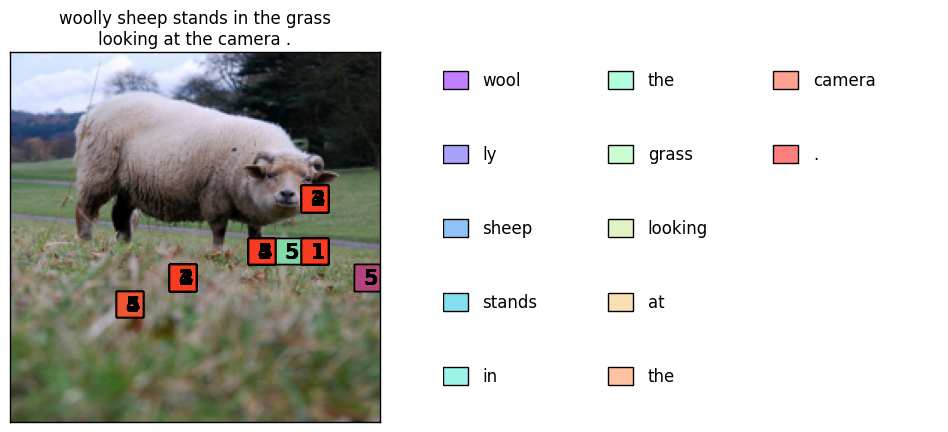

In [371]:
batch = next(dl_iter)
text = batch['text'].to(device)
image = batch['image_teacher'].to(device)
image_raw = batch['image_raw']
padding_mask = batch['padding_mask'].to(device)
token2patch, padding_mask = t_cmli(module, teacher, text, padding_mask, image)
text = text[:, 1:]
for i in range(9):
    plot(image_raw[i], text[i], token2patch[i], padding_mask[i])

In [372]:
j=5

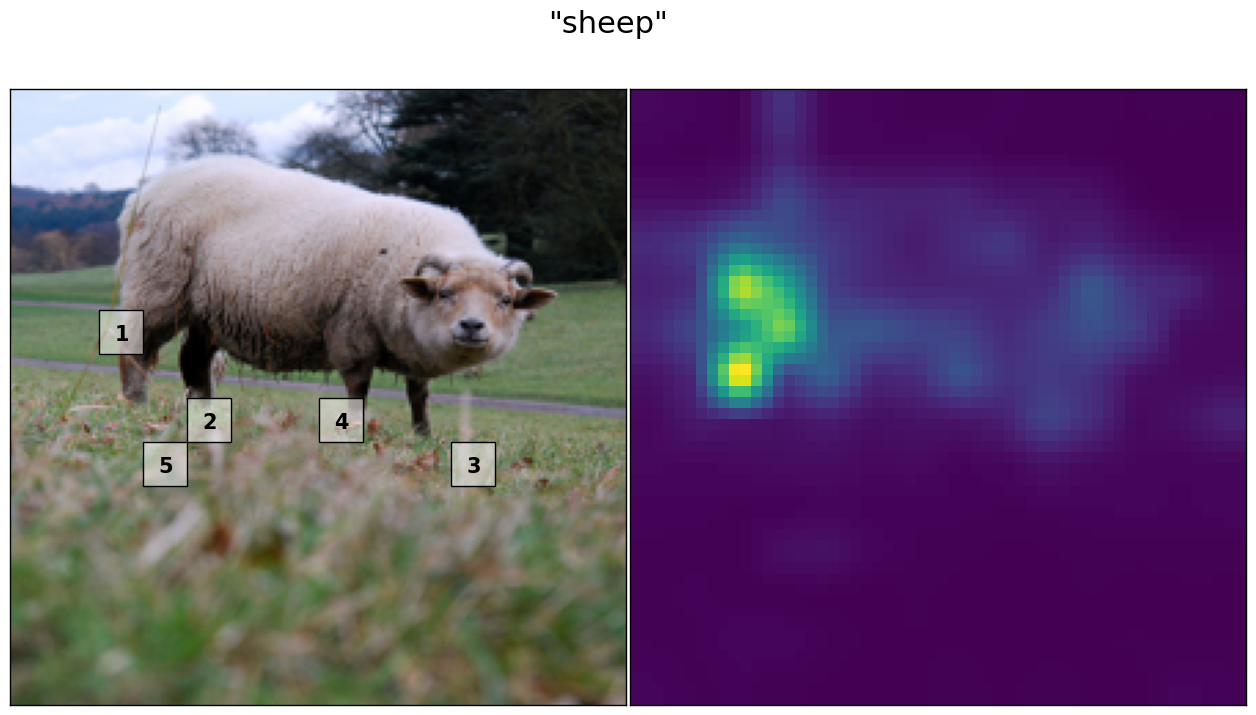

In [373]:
plot_token(image_raw[j], image[j], text[j], token2patch[j], padding_mask[j], 1)